# Problem
Tahoe Health Solutions is losing revenue from HRRP fines for patient readmissions (8000 per patient). THS is considering rolling out an education/monitoring program called CareTracker. CarTracker seems promising (reduced readmissions rate by 40%) but expensive ($1,200 per patient). 

## Talking Points:
1. Should THS implement the program? What are the costs and benefits of the program?
2. How should THS implement the program to maximize savings and minimize readmissions?
3. Assumptions of the models and business implications (Implications of False Postives/Negatives)
4. Clear recommendations moving forward
!['tahoe_data_dict](tahoe_dict.png)

## Primary Business Question: Should THS adopt CareTrackers and extend it to everyone?

In [203]:
pct_readmitted = sum(data.readmit30)/len(data)
pct_readmitted

0.22774988589685075

In [204]:
sum(data.readmit30)

998

Overall, 998 patients, or  **23%** of  the total number of patients from the sample were readmitted within 30 days.

In [22]:
'${:,}'.format(sum(data.readmit30)*8000)

'$7,984,000'

Assuming that the cost of readmittance is 8,000 per patient. **The cost of HRRP fines for readmitted patients over the last year was $7,984,000**

In [23]:
'${:,}'.format(len(data)*1200)

'$5,258,400'

Assuming that the cost of CareTracker is 1,200 uniformly for all patients, **CostTracker would cost $5,258,400 if it were blindly extended to all patients.**

In [24]:
'${:,}'.format(7984000-5258400)

'$2,725,600'

In [224]:
'${:,}'.format(sum(data.readmit30)*.60*8000)

'$4,790,400.0'

**If CostTracker reduces readmission rate by 40%, the cost of HRRP fines would be $4,790,400 after the intervention.**

In [226]:
'${:,}'.format(sum(data.readmit30)*.60*8000 + len(data)*1200)

'$10,048,800.0'

***The total cost of CareTracker applied blindly to all patients plus the reduced HRRP fines would be $10,048,800.***

Unless THS can target at-risk patients and administer CareTracker more precisely, CareTracker is not worth it.

**Could CareTracker be cost-effective if applied to the right subset of patients?** The chief principle of precision medicine is that healthcare providers should make decisions and patient interventions strategically by identifying who needs what kind of care at what time. To do this we must learn from the data and identify the subset of patients who are most at risk to being readmitted. That way, we can provide additional care to high-risk patients and save money on unnecessary interventions/HRRP fines! 

# CareTrackers Optimization Stage 1: Mangerial Segmentaion by EDA

### Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics.model_selection import train_test_split
import sklearn
from scipy import stats

import itertools
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1.5)
sns.set_style('white')
%pylab inline
pylab.rcParams['figure.figsize'] = (30, 15)


Populating the interactive namespace from numpy and matplotlib


## EDA

## Load Data & Preview Data

In [2]:
data = pd.read_csv('data.csv')
data = data.rename(columns={'age' : 'age', 'female': 'female', 'flu_season':'flu_season', 'ed_admit':'ed_admit',
                            'severity score':'severity_score','comorbidity score':'comorbidity_score', 
                            'readmit30':'readmit30'})

In [58]:
data.head()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


In [59]:
data.describe()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,76.847330,0.469192,0.408033,0.809220,22.353263,94.735509,0.227750
std,7.904949,0.499107,0.491525,0.392961,18.005320,57.145155,0.419428
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,70.000000,0.000000,0.000000,1.000000,8.000000,51.000000,0.000000
50%,76.000000,0.000000,0.000000,1.000000,19.000000,86.000000,0.000000
75%,82.000000,1.000000,1.000000,1.000000,32.000000,131.000000,0.000000
max,105.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.000000


## Continuous Variables: Age, Severity Score, & Comorbidity Score

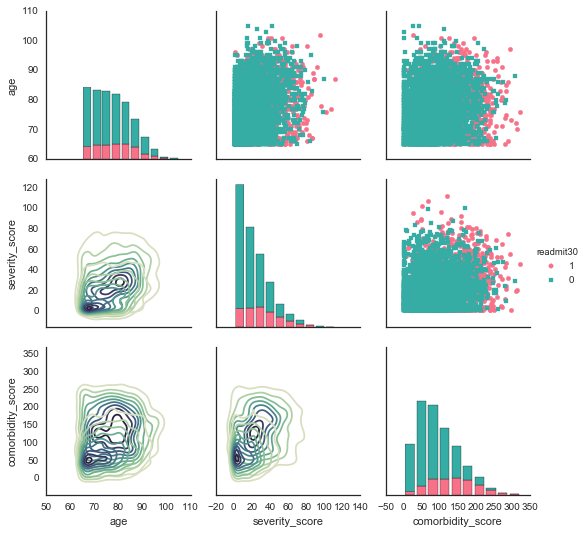

In [93]:
# Scatter Matrix of Continuous Variables
g = sns.PairGrid(data, vars=["age","severity_score","comorbidity_score"],
                 hue="readmit30", palette="husl",
                 hue_kws={"marker": ["o", "s"]}, hue_order=[1,0])
g = g.map_upper(plt.scatter)
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
g = g.map_lower(sns.kdeplot, cmap=cmap, shade=False)
g = g.map_diag(plt.hist)
g = g.add_legend()

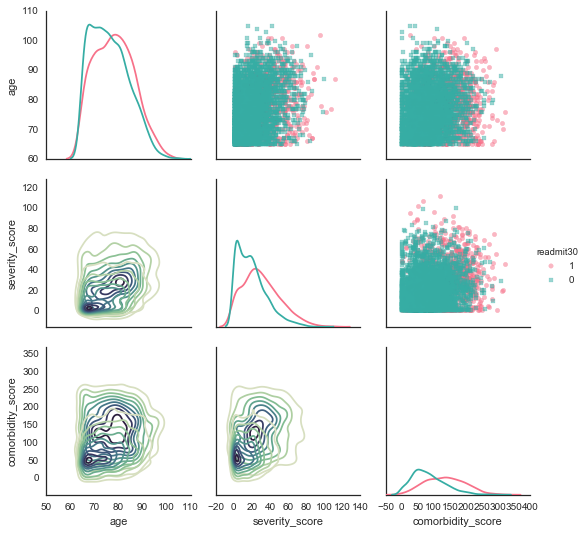

In [55]:
# Scatter Matrix of Continuous Variables with KDE
g = sns.PairGrid(data, vars=["age","severity_score","comorbidity_score"],
                 hue="readmit30", palette="husl",
                 hue_kws={"marker": ["o", "s"]}, hue_order=[1,0])
g = g.map_upper(plt.scatter, alpha=0.5)
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
g = g.map_lower(sns.kdeplot, cmap=cmap, shade=False)
g = g.map_diag(sns.kdeplot)
g = g.add_legend()

### Observations:
- Age does not seem to be a significant factor. 
- There are opportunities to target a select subset of patients with high comorbidity and severity scores. 

### Follow-up questions:
- To what degree does each continuous variable affect readmittance and which are most impactful?



In [20]:
comorbidity_pivot = pd.pivot_table(data,index=["readmit30","flu_season","ed_admit","female"], values=['comorbidity_score'],
                          aggfunc=np.median)
comorbidity_pivot.columns = ['median_comorbidity']
comorbidity_pivot

median_comorbidity
readmit30 flu_season ed_admit female                    
0         0          0        0                     74.0
                              1                     86.0
                     1        0                     76.0
                              1                     78.0
          1          0        0                     76.0
                              1                     79.5
                     1        0                     69.5
                              1                     69.0
1         0          0        0                    148.0
                              1                    100.5
                     1        0                    139.0
                              1                    134.0
          1          0        0                    135.0
                              1                    127.5
                     1        0                    140.0
                              1                    128.0

In [21]:
severity_pivot = pd.pivot_table(data,index=["readmit30","flu_season", "ed_admit", "female"], values=['severity_score'],
                          aggfunc=np.median)
severity_pivot.columns = ['median_severity']
severity_pivot

median_severity
readmit30 flu_season ed_admit female                 
0         0          0        0                   3.0
                              1                   4.0
                     1        0                  18.0
                              1                  21.0
          1          0        0                   3.0
                              1                   4.0
                     1        0                  19.0
                              1                  20.0
1         0          0        0                   4.0
                              1                   2.5
                     1        0                  31.0
                              1                  33.0
          1          0        0                   4.0
                              1                   5.0
                     1        0                  28.0
                              1                  29.0

### Observations:
- Comorbidity seems to be a stronger predictor of readmission rate than severity.

### Zoom in on what matters

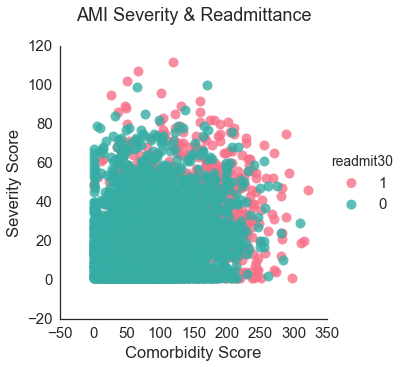

In [130]:
sns.lmplot('comorbidity_score', 'severity_score', 
           data=data, 
           fit_reg=False, 
           #dropna=True,
           hue="readmit30",
           hue_order=[1,0],
           palette="husl",
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('AMI Severity & Readmittance\n')
plt.xlabel('Comorbidity Score')
plt.ylabel('Severity Score')

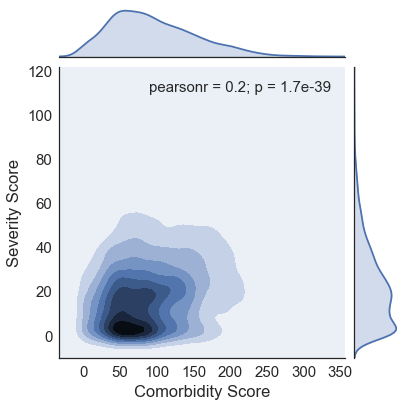

In [137]:
g = sns.jointplot(data.comorbidity_score, data.severity_score, kind='kde')
g.set_axis_labels(xlabel='Comorbidity Score', ylabel='Severity Score')


## Categorical Variables:

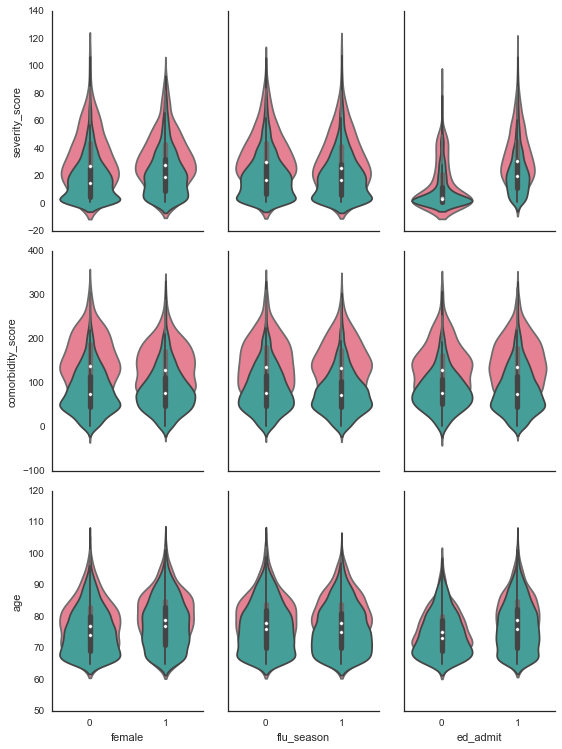

In [72]:
g = sns.PairGrid(data,
                 x_vars=["female", "flu_season", "ed_admit"],
                 y_vars=["severity_score", "comorbidity_score", "age"],
                 palette="husl", hue="readmit30", hue_order=[1,0],
                 aspect=.75, size=3.5)
g.map(sns.violinplot);

### Observations:
- Violin plots emphasize importance of comorbidity score
- Across categorical splits, the only split that looks noteworthy is in the upper-right cell. Severity scores seem to be higher in patients who were admitted to the ED (which makes sense).

### Follow Up Questions:
- These violin plots shows that categorical splits at a first degree do not seem correlate much with readmittance. What about sub-segments and interactions between variables?

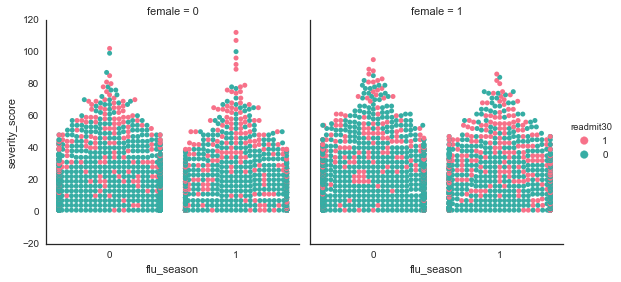

In [75]:
sns.factorplot(x="flu_season", y="severity_score", hue="readmit30",hue_order=[1,0],
               col="female", data=data, kind="swarm", palette="husl")

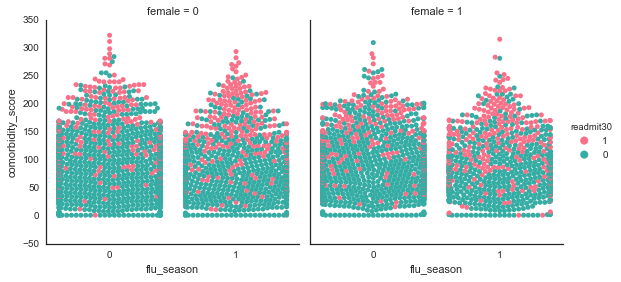

In [79]:
sns.factorplot(x="flu_season", y="comorbidity_score", hue="readmit30",hue_order=[1,0],
               col="female", data=data, kind="swarm", palette="husl")

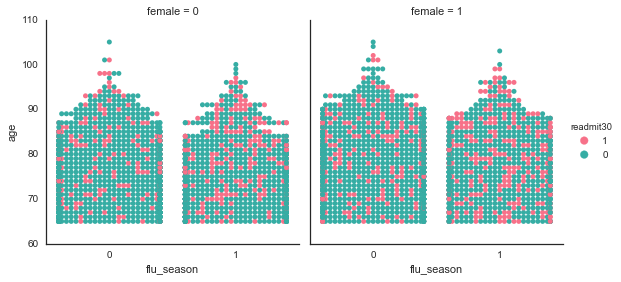

In [80]:
sns.factorplot(x="flu_season", y="age", hue="readmit30",hue_order=[1,0],
               col="female", data=data, kind="swarm", palette="husl")

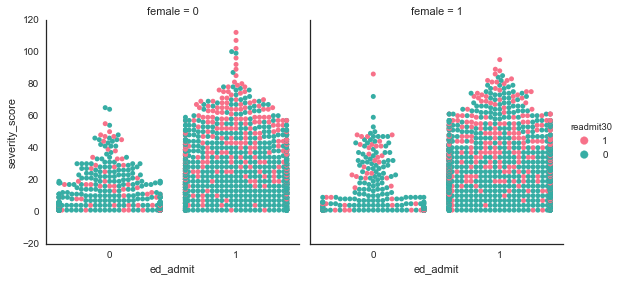

In [81]:
sns.factorplot(x="ed_admit", y="severity_score", hue="readmit30",hue_order=[1,0],
               col="female", data=data, kind="swarm", palette="husl")

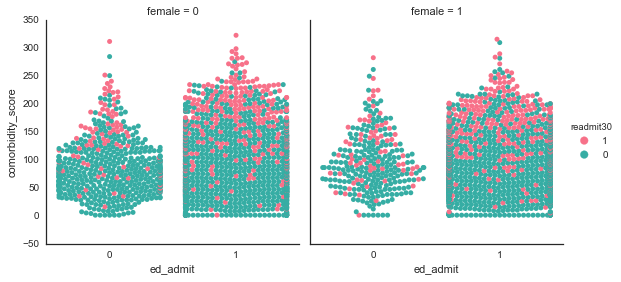

In [82]:
sns.factorplot(x="ed_admit", y="comorbidity_score", hue="readmit30",hue_order=[1,0],
               col="female", data=data, kind="swarm", palette="husl")

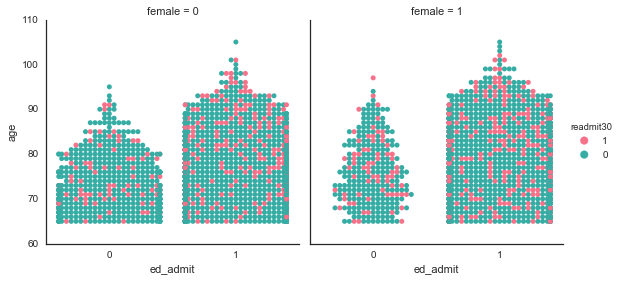

In [83]:
sns.factorplot(x="ed_admit", y="age", hue="readmit30",hue_order=[1,0],
               col="female", data=data, kind="swarm", palette="husl")

# Factor Plot Matrix in One View

!['factor_plot_matrix'](images/factor_matrix2.png)



### Observations:
- Factor plots further emphasize the significance of comorbidity and severity as they relate to readmittance. 
- Hints for managerial segmentation: Comorbidity > 150 and Severity > 50 for high risk of being readmitted.
- Visual indication that there may be a greater number of normally low risk patients (Comorbidity <= 150 and Severity <= 50) who are readmitted during flu season.
- Most of our AMI patients are admitted through the ED. The ED category has more high comorbidity and high severity patients (which makes sense).
- Gender does not seem to be significant.

### Follow Up Questions:
- How much money would THS save if it extended CareTracker to managerial segments based on Comorbidity and Severity scroes alone?
- How does mean readmitance vary across flu season and category segments?

## Segmentation based on Comorbidity and Severity Scores
Since the benefits of CareTracker far outweight the costs, this managerial segmentation will priorize minimizing false negatives over false positives. The segmentation function can be tweaked with different comorbidity and severity thresholds.

In [3]:
# Define 4 patient segments

def define_segments(comorbidity_threshold, severity_threshold):
    
    highest_risk_segment = data.loc[(data.comorbidity_score> comorbidity_threshold) & (data.severity_score>severity_threshold)]
    mid_risk_segment_1 = data.loc[(data.comorbidity_score> comorbidity_threshold) & (data.severity_score<=severity_threshold)]
    mid_risk_segment_2 = data.loc[(data.severity_score> severity_threshold) & (data.comorbidity_score <= comorbidity_threshold)]

    caretracker_patients = pd.concat([highest_risk_segment,mid_risk_segment_1,mid_risk_segment_2])

    low_risk_segment = data.loc[(data.comorbidity_score<= comorbidity_threshold) & (data.severity_score<= severity_threshold)]
    
    return highest_risk_segment, mid_risk_segment_1,mid_risk_segment_2, caretracker_patients, low_risk_segment


highest_risk_segment, mid_risk_segment_1,mid_risk_segment_2, caretracker_patients, low_risk_segment = define_segments(100, 40)

In [4]:
def classification_rates(caretracker_patients,low_risk_segment):
    true_positives = len(caretracker_patients.loc[caretracker_patients.readmit30 == 1])
    false_positives = len(caretracker_patients.loc[caretracker_patients.readmit30 == 0])
    true_negatives = len(low_risk_segment.loc[low_risk_segment.readmit30 == 0])
    false_negatives = len(low_risk_segment.loc[low_risk_segment.readmit30 == 1])
    
    return true_positives,false_positives, true_negatives, false_negatives

In [5]:
def experiment_with_thresholds(objective_metric='f1'):
    comorbidity_linspace = np.linspace(50,200)
    severity_linspace = np.linspace(20,60)
    
    iterator = itertools.product(comorbidity_linspace,severity_linspace)
    performance_dict = {}
    
    for combo in iterator:
        
        highest_risk_segment, mid_risk_segment_1,mid_risk_segment_2, caretracker_patients, low_risk_segment = define_segments(combo[0], combo[1])
        
        tp, fp, tn, fn = classification_rates(caretracker_patients,low_risk_segment)
        
        if objective_metric == 'tpr':
            tpr = tp/(tp+fn)
            performance_dict[combo] = tpr
        elif objective_metric == 'tnr':
            tnr = tn/(tn+fp)
            performance_dict[combo] = tnr
        elif objective_metric == 'precision':
            precision = tp/(tp+fp)
            performance_dict[combo] = precision
        elif objective_metric == 'npv':
            npv = tn/(tn+fn)
            performance_dict[combo] = npv
        elif objective_metric == 'fpr':
            fpr = fp/(fp+tn)
            performance_dict[combo] == fpr
        elif objective_metric == 'fnr':
            fnr = fn/(tp+fn)
            performance_dict[combo] == fnr
        elif objective_metric == 'fdr':
            fdr = fp/(tp+fp)
            performance_dict[combo] == fdr
        elif objective_metric == 'accuracy':
            accuracy = (tp+tn)/(tp+tn+fp+fn)
            performance_dict[combo] == accuracy
        elif objective_metric == 'f1':
            f1 = 2*tp/(2*tp+fp+fn)
            performance_dict[combo] = f1
            
    
    return performance_dict
        
    

### Best thresholds based on F1 score

In [6]:
d = experiment_with_thresholds(objective_metric='f1')

In [7]:
best_comorbidity_thrsh, best_severity_thrsh = max(d, key= d.get)

In [8]:
best_comorbidity_thrsh

126.53061224489795

In [9]:
best_severity_thrsh

43.673469387755105

In [10]:
print("F1 Score of 'best' managerial segmentation: ", d[(200.0, 60.0)])

F1 Score of 'best' managerial segmentation:  0.31647398843930635


**This F1 score is pretty low, Decision Trees could achieve much better results while preserving interpretability**

In [11]:
highest_risk_segment, mid_risk_segment_1,mid_risk_segment_2, caretracker_patients, low_risk_segment = define_segments(best_comorbidity_thrsh, best_severity_thrsh)

In [12]:
tp, fp, tn, fn = classification_rates(caretracker_patients,low_risk_segment)

In [13]:
# Number of moderate-high risk patients who THS would extend CareTracker to:

n_high_mod_risk = len(caretracker_patients)
print("Number of CareTracker Patients:",n_high_mod_risk)
print("Percentage of Total Sample Size:",n_high_mod_risk/len(data))

Number of CareTracker Patients: 1510
Percentage of Total Sample Size: 0.34459151072569605


In [240]:
confusion_matrix = pd.DataFrame([[tp, fn], [fp, tn]])
confusion_matrix.columns = ['Predicted Yes', 'Predicted No']
confusion_matrix.index = ['Actual Yes', 'Actual No']
confusion_matrix

,Predicted Yes,Predicted No
Actual Yes,652,346
Actual No,858,2526


## What would net-revenue be if we went with this segmentation?

In [241]:
hrrp_fines = (fn*8000) + (tp*.6*8000)
caretracker_costs = (tp+fp)*1200
total_costs = hrrp_fines + caretracker_costs
'${:,}'.format(total_costs)

'$7,709,600.0'

In [242]:
net_rev_improvement = 7984000 - total_costs
'${:,}'.format(net_rev_improvement)

'$274,400.0'

*** Net revenue would increase by 274,400  dollars with this managerial segmentation (from the baseline cost of 7,709,600.0 ) ***

## Should THS factor flu season and ED into its segmentation?

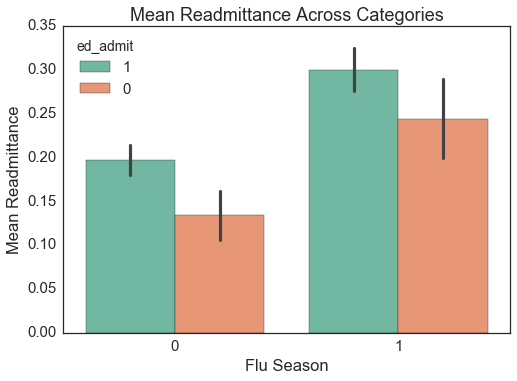

In [360]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.despine()
g = sns.barplot(x="flu_season", y="readmit30", hue='ed_admit', hue_order=[1,0], data=data, palette="Set2")
g.set(xlabel='Flu Season', ylabel='Mean Readmittance', title='Mean Readmittance Across Categories')

### Observations
- Patients that are treated during the flu season are more likely to be readmitted.
- ED doesn't seem to be a noteworthy factor.

### Follow Up Questions:
- What proportion of our sample size is admitted during flu season?

In [169]:
flu_ed_crosstab = pd.crosstab(data.flu_season, data.ed_admit, margins=True)
flu_ed_crosstab

ed_admit,0,1,All
flu_season,,,
0,484,2110,2594
1,352,1436,1788
All,836,3546,4382


In [187]:
print('{} percent of the sample size was admitted during flu season'.format(round(1788/4382, 3)))
print('\n{} percent of all visitors were admitted to the ED'.format(round(3546/4382, 3)))
print('\n{} percent of the flu season visitors were admitted to the ED'.format(round(1436/1788, 3)))


0.408 percent of the sample size was admitted during flu season

0.809 percent of all visitors were admitted to the ED

0.803 percent of the flu season visitors were admitted to the ED


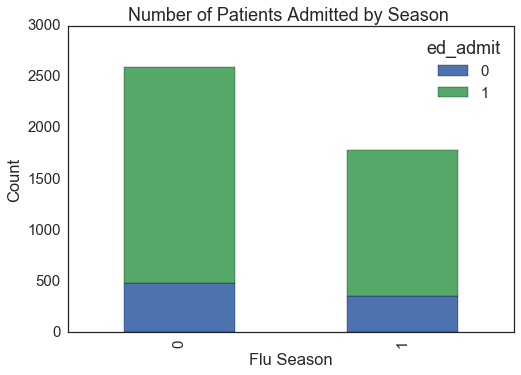

In [175]:
flu_ed_crosstab = pd.crosstab(data.flu_season, data.ed_admit, margins=False).plot.bar(stacked=True)
plt.title('Number of Patients Admitted by Season ')
plt.xlabel('Flu Season')
plt.ylabel('Count')

In [173]:
flu_ed_readmit_crosstab = pd.crosstab([data.flu_season, data.ed_admit], data.readmit30, margins=False)
flu_ed_readmit_crosstab

readmit30               0    1
flu_season ed_admit           
0          0          419   65
           1         1694  416
1          0          266   86
           1         1005  431

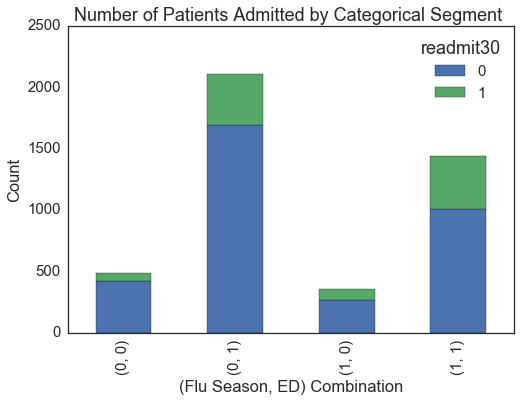

In [176]:
pd.crosstab([data.flu_season, data.ed_admit], data.readmit30, margins=False).plot.bar(stacked=True)
plt.title('Number of Patients Admitted by Categorical Segment ')
plt.xlabel('(Flu Season, ED) Combination')
plt.ylabel('Count')

In [181]:
flu_readmit_crosstab = pd.crosstab(data.flu_season, data.readmit30, margins=True)
flu_readmit_crosstab

readmit30,0,1,All
flu_season,,,
0,2113,481,2594
1,1271,517,1788
All,3384,998,4382


In [191]:
print('{} percent of the sample size was readmitted within 30 days of the initial visit'.format(round(998/4382, 3)))
print('\n{} percent of the non-flu-season visitors were readmitted within 30 days of their initial visit'.format(round(481/2594, 3)))
print('\n{} percent of the flu-season visitors were readmitted within 30 days of their initial visit'.format(round(517/1788, 3)))


0.228 percent of the sample size was readmitted within 30 days of the initial visit

0.185 percent of the non-flu-season visitors were readmitted within 30 days of their initial visit

0.289 percent of the flu-season visitors were readmitted within 30 days of their initial visit


### Since there is an indication that flu-season patients have higher readmittance rates, I'll conduct a two-sample t-test to evaluate if the difference is statistically significant.

In [198]:
"""T-test
Null-Hypothesis: There is no difference in the proportion of readmitted visitors between flu season
and non-flu season patients.
Alternative-Hypothesis: There is a difference in the proportion of readmitted visitors between flu season
and non-flu season patients."""

group1 = data.loc[data.flu_season==0]
group2 = data.loc[data.flu_season==1]

"""Welch's t-test"""

print(stats.ttest_ind(group1.readmit30, group2.readmit30))
print("\nThere is evidence to reject the null hypothesis and affirm a statistically significant difference in\
       readmission rates between flu-season and non-flu-season patients")



Ttest_indResult(statistic=-8.1045397635269811, pvalue=6.8065663205952671e-16)

There is evidence to reject the null hypothesis and affirm a statistically significant difference in       readmission rates between flu-season and non-flu-season patients


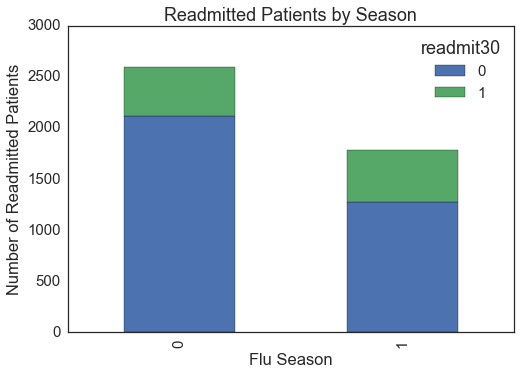

In [362]:
pd.crosstab(data.flu_season, data.readmit30, margins=False).plot.bar(stacked=True)
plt.xlabel('Flu Season')
plt.ylabel('Number of Readmitted Patients')
plt.title('Readmitted Patients by Season')

### Observations
- 41% of the patients from the sample were admitted during the flu season (December - March)
- The proportion of visitors who are admitted to the Emergency Department is more or less equal in the flu season vs the rest of the year.
- The proportion of visitors who were readmitted within 30 days of their first visit is greater in the flu season than during the rest of the year. This difference is statistically significant.

### Follow Questions:
- How can we model a mixture of categorical and continuous to predict whether a patient is going to be readmitted within 30 days?

### Answer:
- Decision Trees! While there are more sophisticated models (tree ensembles, deep learning, SVMs) that can outperform Decision Trees in terms of accurracy, precision, and recall, Decision Trees are ideal for this case because they preserve interpretability. Since the health and lives of THS patients are at stack, it is important for this model to be explainable. 

# CareTrackers Optimization Stage 2: Machine Learning


### Start by spot-checking several classifiers to compare variation in performance.

In [5]:
X = data.drop('readmit30', axis = 1)
Y = data['readmit30']

In [6]:
# Logistic Regression
seed=7
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.805109162584


In [7]:
# LDA
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = LinearDiscriminantAnalysis()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.804193840297


In [8]:
# KNN
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = KNeighborsClassifier()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.774759467865


In [10]:
# Naive Bayes
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = GaussianNB()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.793238576674


In [11]:
# Decision Tree
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = DecisionTreeClassifier()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.706765063813


In [12]:
# Random Forest
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.774987778367


In [13]:
# SVM
kfold = sklearn.model_selection.KFold(n_splits=10, random_state=seed)
model = SVC()
results = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.767000031204


### Why not logistic regression?
- Observations are not independent
- Multicollinearity exists in the data.
- Variable coefficients overemphasizes the effect that flu season has on readmission in comparison to severity and comorbidity scores.

In [42]:
# X = data.drop(['readmit30'], axis = 1)
X = data[['comorbidity_score', 'severity_score', 'female', 'flu_season']]
Y = data['readmit30']

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
lr_model = LogisticRegression()
lr_model = lr_model.fit(x_train, y_train)

In [43]:
lr_model.coef_[0]

array([ 0.01531566,  0.02436531,  0.0676452 ,  0.68235686])

In [49]:
readmit_model = smf.logit("readmit30 ~ female + flu_season + severity_score + comorbidity_score", data=data).fit()
readmit_model.summary()

Optimization terminated successfully.
         Current function value: 0.437431
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              readmit30   No. Observations:                 4382
Model:                          Logit   Df Residuals:                     4377
Method:                           MLE   Df Model:                            4
Date:                Sat, 04 Mar 2017   Pseudo R-squ.:                  0.1847
Time:                        20:55:48   Log-Likelihood:                -1916.8
converged:                       True   LL-Null:                       -2351.1
                                        LLR p-value:                1.046e-186
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.9849      0.128    -31.195      0.000      -4.235      -3.735
female                0.1840      0.081      2.264      0.024       0.025       0.343
flu_season            0.7439      0.082      9.081      0.000       0.583       0.904
severity_score        0.0259      0.002     11.993      0.000       0.022       0.030
comorbidity_score     0.0158      0.001     21.504      0.000       0.014       0.017
=====================================================================================
"""

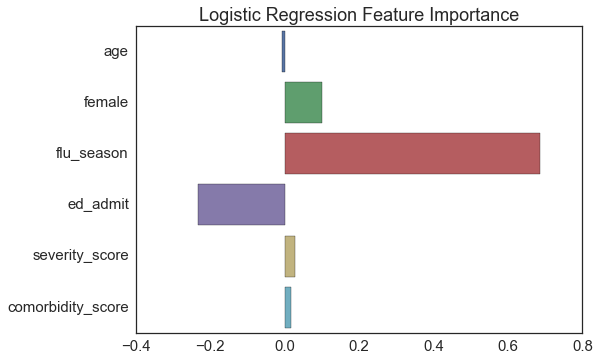

In [306]:
sns.set(font_scale=1.5)
sns.set_style('white')

g = sns.barplot(x=lr_model.coef_[0], y=data.drop(['readmit30'],axis=1).columns)
g = g.set_title('Logistic Regression Feature Importance')

In [46]:
xx.ravel().shape

(91247500,)

In [47]:
data['female'].shape

(4382,)

In [48]:
n_classes = 2
plot_colors = "bry"
plot_step = 0.02

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X.comorbidity_score.min() - 1, X.comorbidity_score.max() + 1
y_min, y_max = X.severity_score.min() - 1, X.severity_score.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = lr_model.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression")
plt.axis('tight')

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X.comorbidity_score.loc[idx], X.severity_score.loc[idx], c=color, label=data.readmit30[i],
                cmap=plt.cm.Paired)

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = lr_model.coef_
intercept = lr_model.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)

for i, color in zip(lr_model.classes_, colors):
    plot_hyperplane(i, color)

plt.show()

ValueError: X has 2 features per sample; expecting 4

In [44]:
# Parameters
n_classes = 2
plot_colors = "bry"
plot_step = 0.02

x_min, x_max = X.comorbidity_score.min() - 1, X.comorbidity_score.max() + 1
y_min, y_max = X.severity_score.min() - 1, X.severity_score.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = lr_model.predict(np.c_[xx.ravel(), yy.ravel(), data['female'], data['flu_season']])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel('Comorbidity Score')
plt.ylabel('Severity Score')
plt.axis("tight")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X.comorbidity_score.loc[idx], X.severity_score.loc[idx], c=color, label=data.readmit30[i],
                cmap=plt.cm.Paired)

plt.axis("tight")

plt.suptitle("Decision Surface Of Decision Tree Trained On Comorbidity and Severity Score Features")
plt.legend()

ValueError: all the input array dimensions except for the concatenation axis must match exactly

### Why not LDA?
Assumes that clusters do not overlap and are well seperated by hyperplanes.

### Why not Naive Bayes?
Assumes that variables are independent (which they are not in this case)

### Why not Random Forest or SVM?
Difficult to interpret and trace business logic.

### Why not KNN?
Mix of continuous and categorical variables does not bode well. Curse of dimensionality if we were to add more features in the future (dimensionality reduction would strip away interpretability).

## Train and Visualize Decision Tree

In [17]:
dt = DecisionTreeClassifier(max_leaf_nodes=16, random_state=99)
# dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)

X = data.drop(['readmit30'], axis = 1)
# X = data[['comorbidity_score','severity_score', 'flu_season']]
Y = data['readmit30']

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
dt = dt.fit(x_train, y_train)

In [18]:
dt.score(x_test,y_test)

0.7916349809885932

In [19]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names,
                        class_names=data.readmit30.values.astype('str'),
                        filled=True, rounded=True)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [20]:
visualize_tree(dt, data.columns)


In [21]:
!ls

CCW140206.pdf                          dt.png
THS_CaseStudy_AnthonyAbercrombie.ipynb images
data.csv                               tahoe_dict.png
dt.dot


In [22]:
import pydot

(graph,) = pydot.graph_from_dot_file('dt.dot')
graph.write_png('dt.png')

True

!['lkj'](dt.png)

### How did the Decision Tree perform?

In [23]:
dt_readmission_predictions = dt.predict(X)

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y, dt_readmission_predictions)


array([[3218,  166],
       [ 657,  341]])

In [25]:
dt.feature_importances_

array([ 0.04241483,  0.        ,  0.050875  ,  0.        ,  0.19025939,
        0.71645079])

In [26]:
X.columns

Index(['age', 'female', 'flu_season', 'ed_admit', 'severity_score',
       'comorbidity_score'],
      dtype='object')

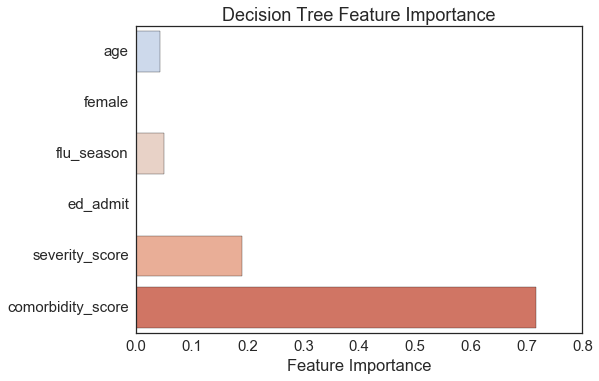

In [41]:
sns.set(font_scale=1.5)
sns.set_style('white')

pal = sns.color_palette("coolwarm", len(dt.feature_importances_))
rank = dt.feature_importances_.argsort().argsort()

g = sns.barplot(x=dt.feature_importances_, y=X.columns, palette=np.array(pal[::])[rank])

plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')

In [34]:
tp= 0
fp= 0
tn= 0
fn= 0
for i in range(len(Y)):
    if (dt_readmission_predictions[i] == 1) & (Y[i] == 1):
        tp += 1
    elif (dt_readmission_predictions[i] == 1) & (Y[i] == 0):
        fp += 1
    elif (dt_readmission_predictions[i] == 0) & (Y[i] == 1):
        fn += 1
    elif (dt_readmission_predictions[i] == 0) & (Y[i] == 0):
        tn += 1


confusion_matrix = pd.DataFrame([[tp, fn], [fp, tn]])
confusion_matrix.columns = ['Predicted Yes', 'Predicted No']
confusion_matrix.index = ['Actual Yes', 'Actual No']
confusion_matrix

,Predicted Yes,Predicted No
Actual Yes,341,657
Actual No,166,3218


### HRRP costs after using Decision Tree to Predict Readmission Rates

In [35]:
hrrp_fines = (fn*8000) + (tp*.6*8000)
caretracker_costs = (tp+fp)*1200
total_costs = hrrp_fines + caretracker_costs
'${:,}'.format(total_costs)

'$7,501,200.0'

### Improvement in Net Revenue From Decision Tree

In [39]:
net_rev_improvement = 7984000 - total_costs
'${:,}'.format(net_rev_improvement)

'$482,800.0'

In [40]:
f1 = 2*tp/(2*tp+fp+fn)
f1

0.453156146179402

### F1 score is better with the Decision Tree than the managerial segmentation and more money is saved ($689,200.0)! Decision tree wins.

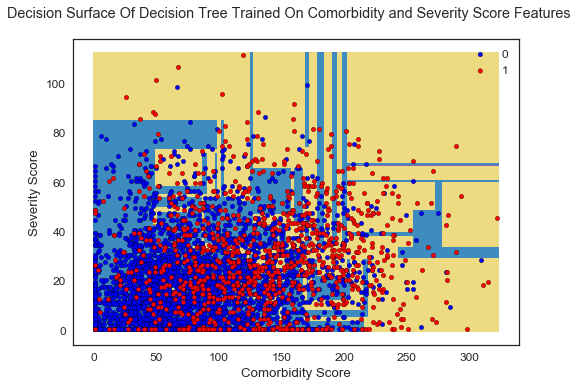

In [158]:
# Parameters
n_classes = 2
plot_colors = "bry"
plot_step = 0.02

x_min, x_max = X.comorbidity_score.min() - 1, X.comorbidity_score.max() + 1
y_min, y_max = X.severity_score.min() - 1, X.severity_score.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.xlabel('Comorbidity Score')
plt.ylabel('Severity Score')
plt.axis("tight")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X.comorbidity_score.loc[idx], X.severity_score.loc[idx], c=color, label=data.readmit30[i],
                cmap=plt.cm.Paired)

plt.axis("tight")

plt.suptitle("Decision Surface Of Decision Tree Trained On Comorbidity and Severity Score Features")
plt.legend()

### Observations:
- Decision Tree trained on Comorbidity and Severity scores only is overfit. 
- Due the current HRRP readmission fee of 8000 dollars and the comparitvely low CareTracker cost of 1200 dollars, it is much better to over-extend caretracker to patients who might not need it.


# Conclusion

In [16]:
do_nothing = [7984000]
cartrack_for_everyone = [10048800]
managerial_segmentation = [7709600]
decision_tree = [7294800]

In [24]:
MRRP_Costs = pd.DataFrame([do_nothing, cartrack_for_everyone, managerial_segmentation, decision_tree])
MRRP_Costs.columns = ['Cost']
MRRP_Costs.index = ['Do Nothing', 'CareTracker For All','Managerial Segmentation','Decision Tree']
MRRP_Costs['$ Savings'] = 7984000 - MRRP_Costs['Cost']
MRRP_Costs['% Savings'] = 1 - (MRRP_Costs['Cost']/7984000)

# MRRP_Costs['% Savings'] = MRRP_Costs['% Savings'].map('{:,.2f}'.format)
# MRRP_Costs['Cost'] = MRRP_Costs['Cost'].map('$ {:,.2f}'.format)
# MRRP_Costs['$ Savings'] = MRRP_Costs['$ Savings'].map('$ {:,.2f}'.format)

MRRP_Costs


,Cost,$ Savings,% Savings
Do Nothing,7984000,0,0.000000
CareTracker For All,10048800,-2064800,-0.258617
Managerial Segmentation,7709600,274400,0.034369
Decision Tree,7294800,689200,0.086323


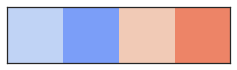

In [34]:
pal = sns.color_palette("coolwarm", len(MRRP_Costs))
rank = MRRP_Costs['% Savings'].argsort().argsort().values

palette=np.array(pal[::])[rank]

sns.palplot(palette)



array([2, 3, 1, 0])

***THS should use machine learning (e.g. Decision Tree) to identify patients that are likely to be readmitted. THS can then extend the CareTracker program to these high risk patients to minimize HRRP fines and patient readmission.***

# Continued EDA of Joint and Conditional Probabilities

In [59]:
# readmit and flu
readmit_flu = pd.crosstab(data.readmit30, data.flu_season)

readmit_flu_row_sum = float(readmit_flu[readmit_flu.index==1].sum(axis=1))
no_readmit_flue_row_sum = float(readmit_flu[readmit_flu.index==0].sum(axis=1))

readmit_flu_conditional = readmit_flu.copy()

readmit_flu_conditional.ix[0] = readmit_flu_conditional.ix[0] / no_readmit_flue_row_sum
readmit_flu_conditional.ix[1] = readmit_flu_conditional.ix[1] / readmit_flu_row_sum


print("Conditional Probabilities")
readmit_flu_conditional

Conditional Probabilities


flu_season,0,1
readmit30,,
0,0.624409,0.375591
1,0.481964,0.518036


In [60]:
# readmit and ed_admit
readmit_ed = pd.crosstab(data.readmit30, data.ed_admit)

readmit_ed_row_sum = float(readmit_ed[readmit_ed.index==1].sum(axis=1))
no_readmit_ed_row_sum = float(readmit_ed[readmit_ed.index==0].sum(axis=1))

readmit_ed_conditional = readmit_ed.copy()

readmit_ed_conditional.ix[0] = readmit_ed_conditional.ix[0] / no_readmit_ed_row_sum
readmit_ed_conditional.ix[1] = readmit_ed_conditional.ix[1] / readmit_ed_row_sum


print("Conditional Probabilities")
readmit_ed_conditional


Conditional Probabilities


ed_admit,0,1
readmit30,,
0,0.202423,0.797577
1,0.151303,0.848697


In [61]:
# readmit and female
readmit_female = pd.crosstab(data.readmit30, data.female)

readmit_female_row_sum = float(readmit_female[readmit_female.index==1].sum(axis=1))
no_readmit_female_row_sum = float(readmit_female[readmit_female.index==0].sum(axis=1))

readmit_female_conditional = readmit_female.copy()

readmit_female_conditional.ix[0] = readmit_female_conditional.ix[0] / no_readmit_female_row_sum
readmit_female_conditional.ix[1] = readmit_female_conditional.ix[1] / readmit_female_row_sum


print("Conditional Probabilities")
readmit_female_conditional

Conditional Probabilities


female,0,1
readmit30,,
0,0.542258,0.457742
1,0.491984,0.508016


In [63]:
crosstab_conditional = pd.crosstab([data.ed_admit, data.female, data.flu_season], data.readmit30,  margins=True)
crosstab_conditional

readmit30                      0    1   All
ed_admit female flu_season                 
0        0      0            286   35   321
                1            180   48   228
         1      0            133   30   163
                1             86   38   124
1        0      0            865  207  1072
                1            504  201   705
         1      0            829  209  1038
                1            501  230   731
All                         3384  998  4382

In [67]:
p_no_readmit = []
p_readmit = []
for i,row in crosstab_conditional.iterrows():
    p_no_readmit.append(row[0]/row[2])
    p_readmit.append(row[1]/row[2])
    
crosstab_conditional['prob_readmit'] = p_readmit
crosstab_conditional['prob_no_readmit'] = p_no_readmit

crosstab_conditional

readmit30                      0    1   All  prob_readmit  prob_no_readmit
ed_admit female flu_season                                                
0        0      0            286   35   321      0.109034         0.890966
                1            180   48   228      0.210526         0.789474
         1      0            133   30   163      0.184049         0.815951
                1             86   38   124      0.306452         0.693548
1        0      0            865  207  1072      0.193097         0.806903
                1            504  201   705      0.285106         0.714894
         1      0            829  209  1038      0.201349         0.798651
                1            501  230   731      0.314637         0.685363
All                         3384  998  4382      0.227750         0.772250

# Probability of Readmittance for each Managerial Cluster

In [81]:
crosstab_conditional.prob_readmit.argsort().argsort().values

array([0, 4, 1, 7, 2, 6, 3, 8, 5])

In [35]:
sns.set(font_scale=1.2)
sns.set_style('white')

pal = sns.color_palette("coolwarm", len(crosstab_conditional))
rank = crosstab_conditional.prob_readmit.argsort().argsort().values
g = sns.barplot(x=crosstab_conditional.index, y = crosstab_conditional['prob_readmit'].values, palette=np.array(pal[::])[rank])
plt.xticks(rotation=60)
plt.xlabel('(ED, Female, Flu Season) Segment Combinations')
plt.ylabel('Probability of Readmission Given Segment Combo')
plt.title('Conditional Probability of Readmission Given Categorical Segment Membership\n')

NameError: name 'crosstab_conditional' is not defined